In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

import time
from tqdm import tqdm


In [2]:
df_blocks = []

In [3]:
df_blocks.append(pd.read_csv("capture20110815.binetflow", encoding='utf-8'))

In [4]:
df_blocks[0].columns

Index(['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
       'Label'],
      dtype='object')

In [5]:
for i, df in enumerate(df_blocks):
    df_blocks[i].rename(str.lower, axis='columns', inplace=True)
    df_blocks[i].rename(str.strip, axis='columns', inplace=True)
    df_blocks[i].drop(
        labels=['starttime', 'srcaddr', 'sport', 'dstaddr', 'dport'], axis=1, inplace=True)
    df_blocks[i].rename(
        columns={'totpkts': 'tot_pkts', 'totbytes': 'tot_bytes', 'srcbytes': 'src_bytes'}, inplace=True) 

In [6]:
df_blocks[0].columns

Index(['dur', 'proto', 'dir', 'state', 'stos', 'dtos', 'tot_pkts', 'tot_bytes',
       'src_bytes', 'label'],
      dtype='object')

In [7]:
df_blocks[0].sum

<bound method DataFrame.sum of                  dur proto    dir state  stos  dtos  tot_pkts  tot_bytes  \
0        1065.731934   udp    <->   CON   0.0   0.0         2        252   
1        1471.787109   udp    <->   CON   0.0   0.0         2        252   
2        1095.947266   udp    <->   CON   0.0   0.0         2        288   
3        2896.377197   udp    <->   CON   0.0   0.0         3        433   
4        1384.708008   udp    <->   CON   0.0   0.0         2        288   
...              ...   ...    ...   ...   ...   ...       ...        ...   
1121071     0.000482   udp    <->   CON   0.0   0.0         2        132   
1121072     0.000478   tcp     ->  S_SA   0.0   0.0         2        124   
1121073     0.000072   tcp     ->  S_SA   0.0   0.0         2        148   
1121074     0.000000   udp     ->   INT   0.0   NaN         1        191   
1121075     0.000000   tcp     ?>   FA_   0.0   NaN         1         60   

         src_bytes                               label  

In [8]:
df_blocks[0] = df_blocks[0].dropna()

In [9]:
df_blocks[0].sum

<bound method DataFrame.sum of                  dur proto    dir state  stos  dtos  tot_pkts  tot_bytes  \
0        1065.731934   udp    <->   CON   0.0   0.0         2        252   
1        1471.787109   udp    <->   CON   0.0   0.0         2        252   
2        1095.947266   udp    <->   CON   0.0   0.0         2        288   
3        2896.377197   udp    <->   CON   0.0   0.0         3        433   
4        1384.708008   udp    <->   CON   0.0   0.0         2        288   
...              ...   ...    ...   ...   ...   ...       ...        ...   
1121069     0.001641   udp    <->   CON   0.0   0.0         2        516   
1121070     0.000506   udp    <->   CON   0.0   0.0         2        134   
1121071     0.000482   udp    <->   CON   0.0   0.0         2        132   
1121072     0.000478   tcp     ->  S_SA   0.0   0.0         2        124   
1121073     0.000072   tcp     ->  S_SA   0.0   0.0         2        148   

         src_bytes                            label  
0 

In [10]:
for i, df in enumerate(df_blocks):
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(dupli, "fully duplicate rows to remove")
    s = df.shape[0]
    df_blocks[i].drop_duplicates(inplace=True)
    print(s, '->', df_blocks[i].shape[0])
    df_blocks[i].reset_index(drop=True, inplace=True)


373034 fully duplicate rows to remove
1031784 -> 658750


C:\Users\METE\AppData\Local\Temp\ipykernel_3940\2271357685.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blocks[i].drop_duplicates(inplace=True)


In [11]:
df_blocks[0].sum

<bound method DataFrame.sum of                 dur proto    dir state  stos  dtos  tot_pkts  tot_bytes  \
0       1065.731934   udp    <->   CON   0.0   0.0         2        252   
1       1471.787109   udp    <->   CON   0.0   0.0         2        252   
2       1095.947266   udp    <->   CON   0.0   0.0         2        288   
3       2896.377197   udp    <->   CON   0.0   0.0         3        433   
4       1384.708008   udp    <->   CON   0.0   0.0         2        288   
...             ...   ...    ...   ...   ...   ...       ...        ...   
658745     0.056914   udp    <->   CON   0.0   0.0         2        132   
658746     0.000176   tcp     ->  S_SA   0.0   0.0         2        124   
658747     0.001641   udp    <->   CON   0.0   0.0         2        516   
658748     0.000478   tcp     ->  S_SA   0.0   0.0         2        124   
658749     0.000072   tcp     ->  S_SA   0.0   0.0         2        148   

        src_bytes                            label  
0             1

In [12]:
print("\nEncoding categorical features...")
# Encode protocol type
protocol_encoder = LabelEncoder()
df_blocks[0]['proto'] = protocol_encoder.fit_transform(df_blocks[0]['proto'])
print(df_blocks[0].sum)


Encoding categorical features...
<bound method DataFrame.sum of                 dur  proto    dir state  stos  dtos  tot_pkts  tot_bytes  \
0       1065.731934      5    <->   CON   0.0   0.0         2        252   
1       1471.787109      5    <->   CON   0.0   0.0         2        252   
2       1095.947266      5    <->   CON   0.0   0.0         2        288   
3       2896.377197      5    <->   CON   0.0   0.0         3        433   
4       1384.708008      5    <->   CON   0.0   0.0         2        288   
...             ...    ...    ...   ...   ...   ...       ...        ...   
658745     0.056914      5    <->   CON   0.0   0.0         2        132   
658746     0.000176      4     ->  S_SA   0.0   0.0         2        124   
658747     0.001641      5    <->   CON   0.0   0.0         2        516   
658748     0.000478      4     ->  S_SA   0.0   0.0         2        124   
658749     0.000072      4     ->  S_SA   0.0   0.0         2        148   

        src_bytes     

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\512508215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blocks[0]['proto'] = protocol_encoder.fit_transform(df_blocks[0]['proto'])


In [13]:
df_blocks[0].columns

Index(['dur', 'proto', 'dir', 'state', 'stos', 'dtos', 'tot_pkts', 'tot_bytes',
       'src_bytes', 'label'],
      dtype='object')

In [14]:
print("\nNormalizing numerical features...")
scaler = MinMaxScaler()
numerical_features = ['tot_bytes', 'tot_pkts', 'dur']
df_blocks[0][numerical_features] = scaler.fit_transform(df_blocks[0][numerical_features])
print(df_blocks[0].sum)


Normalizing numerical features...
<bound method DataFrame.sum of                  dur  proto    dir state  stos  dtos      tot_pkts  \
0       2.914176e-01      5    <->   CON   0.0   0.0  2.521325e-07   
1       4.024508e-01      5    <->   CON   0.0   0.0  2.521325e-07   
2       2.996798e-01      5    <->   CON   0.0   0.0  2.521325e-07   
3       7.919958e-01      5    <->   CON   0.0   0.0  5.042651e-07   
4       3.786395e-01      5    <->   CON   0.0   0.0  2.521325e-07   
...              ...    ...    ...   ...   ...   ...           ...   
658745  1.556277e-05      5    <->   CON   0.0   0.0  2.521325e-07   
658746  4.812607e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   
658747  4.487209e-07      5    <->   CON   0.0   0.0  2.521325e-07   
658748  1.307060e-07      4     ->  S_SA   0.0   0.0  2.521325e-07   
658749  1.968794e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   

           tot_bytes  src_bytes                            label  
0       4.784128e-08      

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1778259841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blocks[0][numerical_features] = scaler.fit_transform(df_blocks[0][numerical_features])


In [15]:
df_blocks[0].label

0         flow=Background-UDP-Established
1         flow=Background-UDP-Established
2         flow=Background-UDP-Established
3         flow=Background-UDP-Established
4         flow=Background-UDP-Established
                       ...               
658745    flow=Background-UDP-Established
658746    flow=Background-TCP-Established
658747    flow=Background-UDP-Established
658748    flow=Background-TCP-Established
658749    flow=Background-TCP-Established
Name: label, Length: 658750, dtype: object

In [16]:
label_processed = df_blocks[0].label.apply(lambda x: 'Background' if 'background' in str(x).lower() else 'Botnet')

df_blocks[0].label = label_processed

df_blocks[0].head

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\3645695894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blocks[0].label = label_processed


<bound method NDFrame.head of                  dur  proto    dir state  stos  dtos      tot_pkts  \
0       2.914176e-01      5    <->   CON   0.0   0.0  2.521325e-07   
1       4.024508e-01      5    <->   CON   0.0   0.0  2.521325e-07   
2       2.996798e-01      5    <->   CON   0.0   0.0  2.521325e-07   
3       7.919958e-01      5    <->   CON   0.0   0.0  5.042651e-07   
4       3.786395e-01      5    <->   CON   0.0   0.0  2.521325e-07   
...              ...    ...    ...   ...   ...   ...           ...   
658745  1.556277e-05      5    <->   CON   0.0   0.0  2.521325e-07   
658746  4.812607e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   
658747  4.487209e-07      5    <->   CON   0.0   0.0  2.521325e-07   
658748  1.307060e-07      4     ->  S_SA   0.0   0.0  2.521325e-07   
658749  1.968794e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   

           tot_bytes  src_bytes       label  
0       4.784128e-08        145  Background  
1       4.784128e-08        145  Back

In [17]:
# Label encoding for the target variable
le = LabelEncoder()
df_blocks[0]['label'] = le.fit_transform(df_blocks[0]['label'])

# Normalizing/Standardizing the features
features = df_blocks[0].drop('label', axis=1)
labels = df_blocks[0]['label']

df_blocks[0].sum

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\222848021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blocks[0]['label'] = le.fit_transform(df_blocks[0]['label'])


<bound method DataFrame.sum of                  dur  proto    dir state  stos  dtos      tot_pkts  \
0       2.914176e-01      5    <->   CON   0.0   0.0  2.521325e-07   
1       4.024508e-01      5    <->   CON   0.0   0.0  2.521325e-07   
2       2.996798e-01      5    <->   CON   0.0   0.0  2.521325e-07   
3       7.919958e-01      5    <->   CON   0.0   0.0  5.042651e-07   
4       3.786395e-01      5    <->   CON   0.0   0.0  2.521325e-07   
...              ...    ...    ...   ...   ...   ...           ...   
658745  1.556277e-05      5    <->   CON   0.0   0.0  2.521325e-07   
658746  4.812607e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   
658747  4.487209e-07      5    <->   CON   0.0   0.0  2.521325e-07   
658748  1.307060e-07      4     ->  S_SA   0.0   0.0  2.521325e-07   
658749  1.968794e-08      4     ->  S_SA   0.0   0.0  2.521325e-07   

           tot_bytes  src_bytes  label  
0       4.784128e-08        145      0  
1       4.784128e-08        145      0  
2    

In [18]:
# Select the first 1000 rows
df_blocks_div = df_blocks[0].iloc[:]


x = df_blocks_div.drop(['dir', 'label', 'state'], axis=1)
y = df_blocks_div.label

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
   x, 
   y,
   test_size=0.2,
   random_state=42,
   stratify=y
)

Random Forest Progress:   0%|           [ time left: ? ]

Initializing the Random Forest classifier...


Random Forest Progress:  10%|█          [ time left: 00:04 ]

Starting training...


Random Forest Progress:  70%|███████    [ time left: 00:24 ]

Training complete.
Making predictions...


Random Forest Progress: 100%|██████████ [ time left: 00:00 ]
C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1039685848.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Accuracy"], y=[accuracy], palette="coolwarm")


Predictions complete.
Evaluating the model...
Evaluation complete.
Accuracy: 0.9742618595825427
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    127465
           1       0.94      0.22      0.36      4285

    accuracy                           0.97    131750
   macro avg       0.96      0.61      0.67    131750
weighted avg       0.97      0.97      0.97    131750



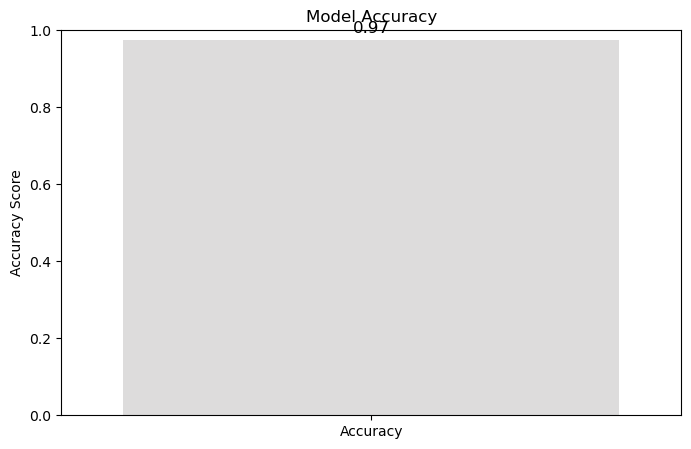

<Figure size 1000x600 with 0 Axes>

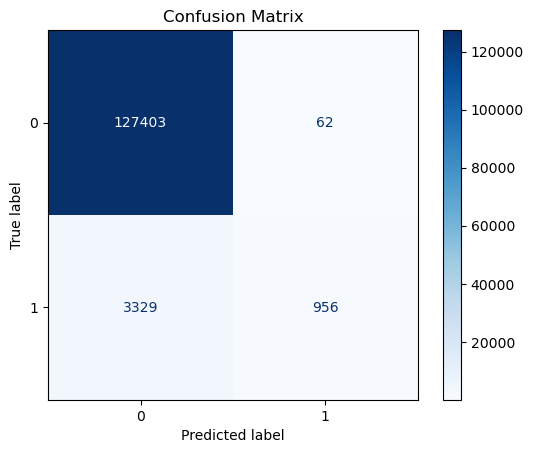

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1039685848.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=[f"Feature {i}" for i in range(len(feature_importances))], palette="viridis")


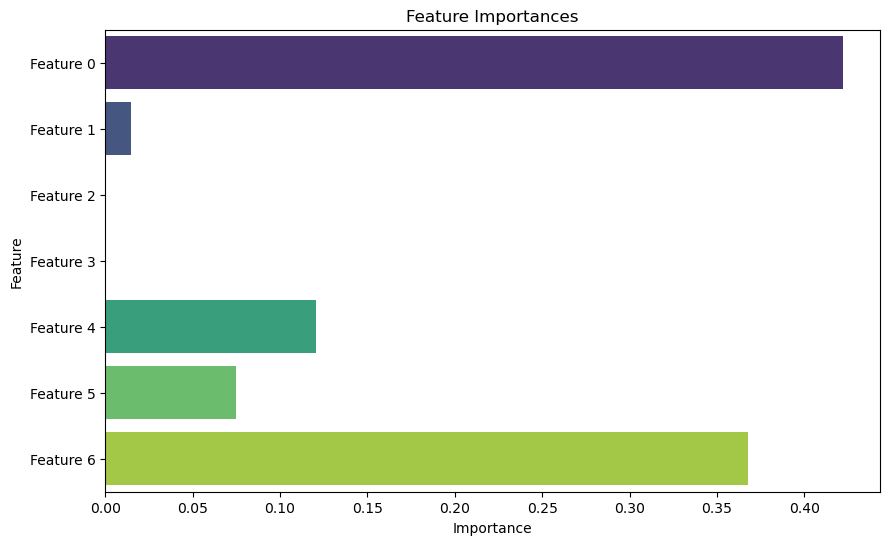

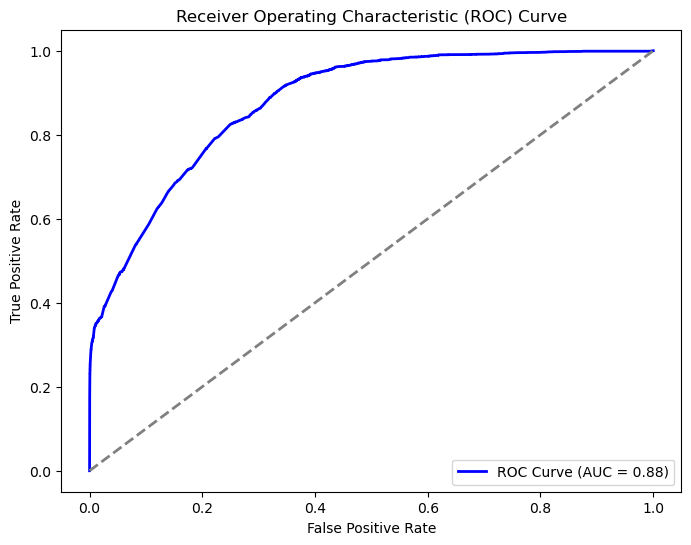

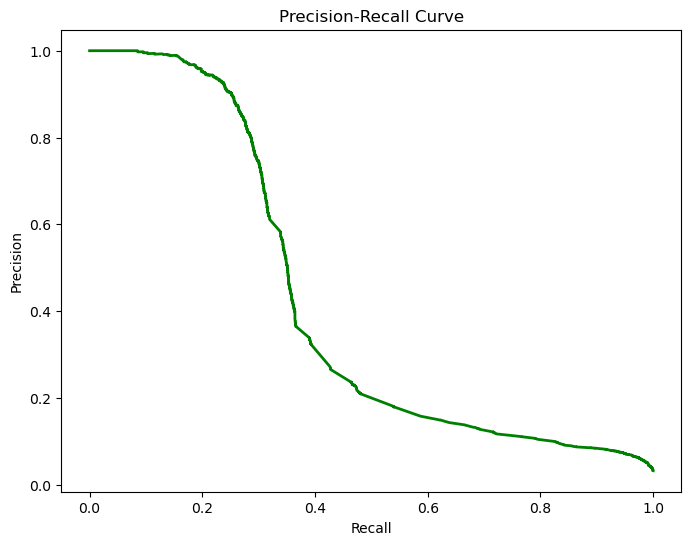

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1039685848.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="pastel")


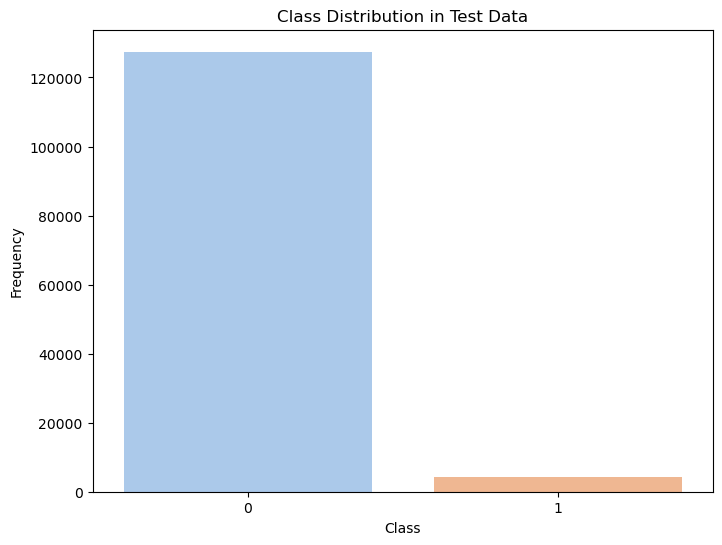

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1039685848.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Label'], palette="pastel")


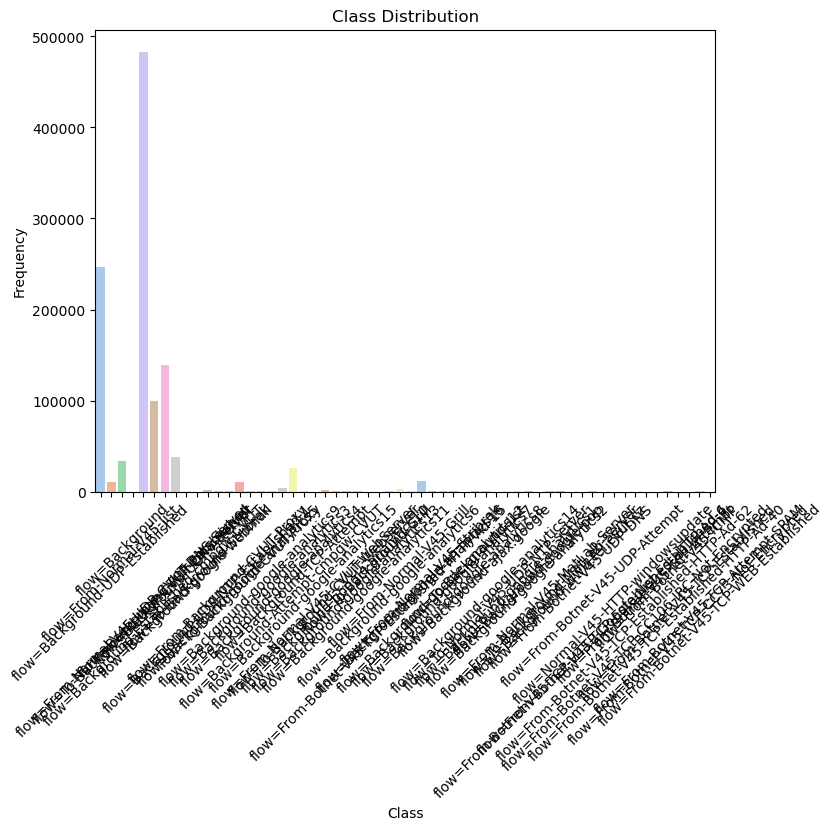

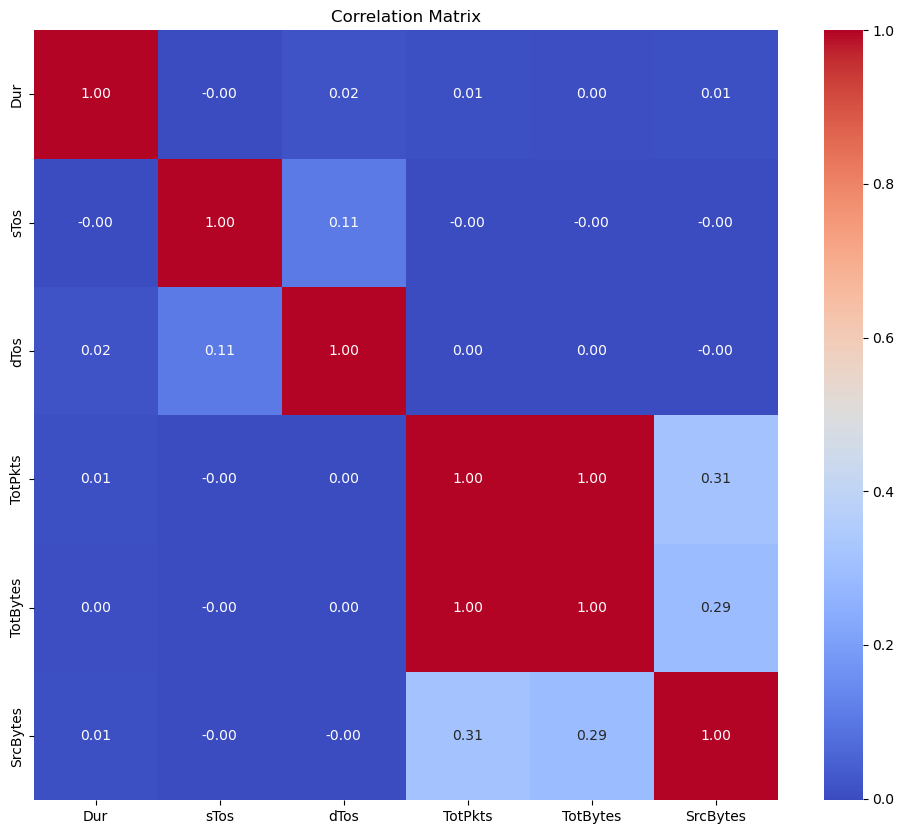

C:\Users\METE\AppData\Local\Temp\ipykernel_3940\1039685848.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Unique Rows", "Duplicate Rows"], y=[df.shape[0] - duplicate_count, duplicate_count], palette="Set2")


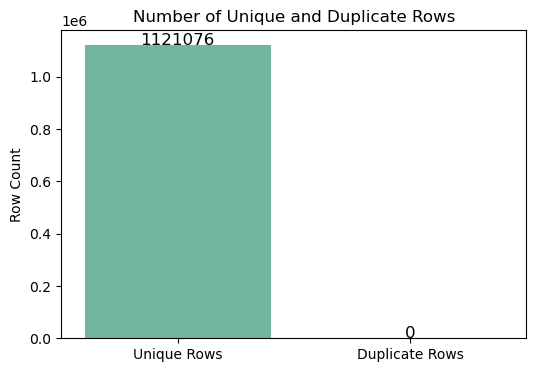

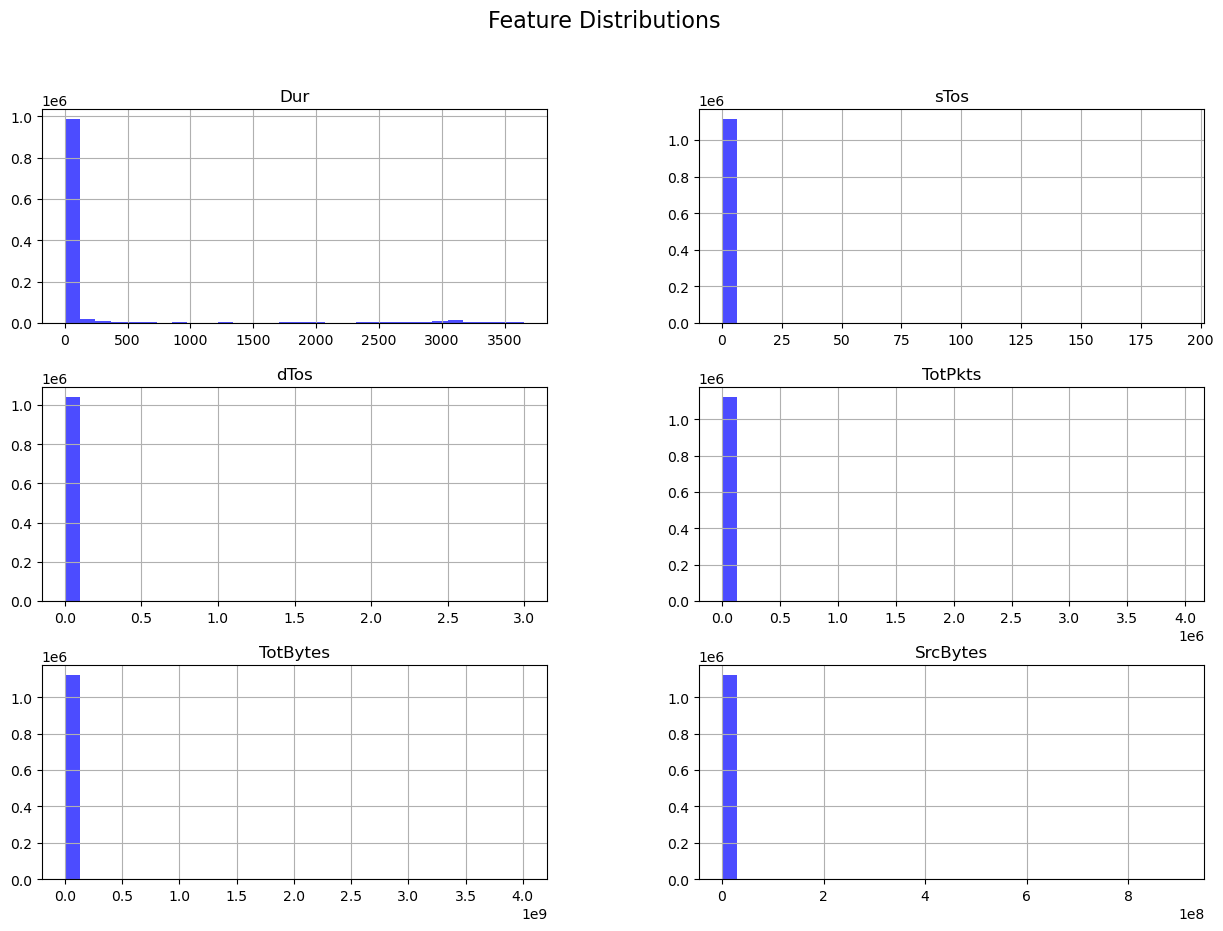

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Simulate progress for training and evaluation
with tqdm(total=100, desc="Random Forest Progress", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    print("Initializing the Random Forest classifier...")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    time.sleep(0.5)  # Simulate a small delay
    pbar.update(10)
    
    print("Starting training...")
    rf_classifier.fit(X_train, y_train)
    pbar.update(60)  # Assume training takes a significant portion
    print("Training complete.")
    
    print("Making predictions...")
    y_pred = rf_classifier.predict(X_test)
    pbar.update(20)
    print("Predictions complete.")
    
    print("Evaluating the model...")
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    pbar.update(10)
    print("Evaluation complete.")

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 1. Accuracy Graph
plt.figure(figsize=(8, 5))
sns.barplot(x=["Accuracy"], y=[accuracy], palette="coolwarm")
plt.title("Model Accuracy")
plt.ylim(0, 1)
plt.ylabel("Accuracy Score")
plt.xlabel("")
for i, v in enumerate([accuracy]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

# 2. Confusion Matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# 3. Feature Importances
if hasattr(rf_classifier, "feature_importances_"):
    feature_importances = rf_classifier.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=[f"Feature {i}" for i in range(len(feature_importances))], palette="viridis")
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 4. ROC and AUC Curve (Binary classification)
if len(rf_classifier.classes_) == 2:
    y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# 5. Precision-Recall Curve
if len(rf_classifier.classes_) == 2:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

# 6. Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="pastel")
plt.title("Class Distribution in Test Data")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükleyin
df = pd.read_csv("capture20110815.binetflow")

# 1. Sınıf Dağılımı
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Label'], palette="pastel")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Sınıflar uzunsa yatayda yerleştir
plt.show()

# 2. Korelasyon Matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 3. Tekrar Eden Satırların Sayısı
duplicate_rows = df[df.duplicated()]
duplicate_count = duplicate_rows.shape[0]

plt.figure(figsize=(6, 4))
sns.barplot(x=["Unique Rows", "Duplicate Rows"], y=[df.shape[0] - duplicate_count, duplicate_count], palette="Set2")
plt.title("Number of Unique and Duplicate Rows")
plt.ylabel("Row Count")
for i, v in enumerate([df.shape[0] - duplicate_count, duplicate_count]):
    plt.text(i, v + 10, str(v), ha='center', fontsize=12)
plt.show()

# 4. Özellik Dağılımları
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns].hist(bins=30, figsize=(15, 10), color='blue', alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()




In [5]:
data.resample('T', on='StartTime').count()['StartTime'].plot()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.savefig('Fig1.png')
plt.show()

NameError: name 'data' is not defined

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Örnek bir veri kümesi yükleme (kendi verinizi buraya ekleyin)
# data = pd.read_csv("your_dataset.csv")  # Kendi dosyanızı yükleyin
# Örnek veri oluşturma
df_blocks[0] = pd.DataFrame({
    "StartTime": pd.date_range(start="2025-01-01", periods=20, freq="H")  # Saatlik veri
})

# StartTime'i tarih ve saat olarak dönüştürün (eğer değilse)
df_blocks[0]['StartTime'] = pd.to_datetime(data['StartTime'])

# StartTime'e göre frekans hesaplama
frequency = df_blocks[0]['StartTime'].dt.floor('H').value_counts().sort_index()

# Frekans grafiğini çizdirme
plt.figure(figsize=(10, 6))
frequency.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('StartTime Frekans Grafiği', fontsize=14)
plt.xlabel('Başlangıç Zamanı', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\METE\AppData\Local\Temp\ipykernel_16316\1476477382.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "StartTime": pd.date_range(start="2025-01-01", periods=20, freq="H")  # Saatlik veri


NameError: name 'df_blocks' is not defined